In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from tsp import AnnealingSolver
from mst_prim import prim_mst, createRoutes
from leach import LeachSolver
from nemo import evaluate_nemo
import util
from util import lighten_color
import seaborn as sns
from util import centroid_label, ch_label, coordinator_label, worker_label, ccolor, cmarker
from topology import get_lognorm_hist
import topology

#### Topology Setup

In [6]:
seed = 4
np.random.seed(seed)

avg = 50
c_capacity = 50

H, bins = get_lognorm_hist()
coords_df = topology.coords_fit()
coord_dict = {"fit": coords_df}
device_number = coords_df.shape[0]
max_resources = device_number * avg - c_capacity

df_dict_topologies = topology.create_topologies_from_dict(coord_dict, H, max_resources, c_capacity,
                                                          weights=(1, avg * 2), dist="lognorm", with_clustering=True,
                                                          kmin=2, kmax=30, kseed=10)

Creating df for fit
Optimal k is 3
Done


In [7]:
t_label = "fit"
prim_df, c_coords, base_col, slot_columns, centroids, opt_k, sil = df_dict_topologies[t_label]
prim_df["weight_1"] = 1
prim_df["weight_2"] = 2
coords = prim_df[["x", "y"]].to_numpy()

eval_matrix = {}
prim_df

,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,...,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1,cluster,weight_1,weight_2
0,4.56190,6.84360,0.000000,coordinator,9223372036854775807,0,50,50,50,50,...,50,50,50,50,50,50,50,-1,1,2
1,-4.17850,-6.91490,16.300028,worker,9223372036854775807,12,50,49,45,55,...,44,45,45,27,21,64,4,0,1,2
2,-1.26250,-2.25620,10.804166,worker,9223372036854775807,1,50,53,52,55,...,48,45,34,91,29,178,0,0,1,2
3,-0.14588,-2.82470,10.753568,worker,9223372036854775807,2,50,49,55,51,...,43,34,31,50,44,22,12,0,1,2
4,6.22700,-0.84394,7.865801,worker,9223372036854775807,3,50,48,54,59,...,46,44,93,79,17,19,73,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,14.10200,-4.01350,14.453032,worker,9223372036854775807,2,50,53,51,57,...,51,82,38,25,82,31,8,0,1,2
429,13.88500,-5.90200,15.791470,worker,9223372036854775807,2,50,53,52,53,...,62,45,35,27,57,104,58,0,1,2
430,12.97500,-5.61380,15.032201,worker,9223372036854775807,1,50,53,50,49,...,40,45,34,26,23,45,23,0,1,2
431,-8.41010,8.46420,13.072839,worker,9223372036854775807,1,50,52,50,45,...,41,61,43,26,65,83,4,0,1,2


In [8]:
print("Required:", prim_df["weight"].sum(), "Available:", prim_df["capacity_100"].sum())
colors, light_colors, palette = util.get_color_list(opt_k)
palette

Required: 3088 Available: 21650


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)]

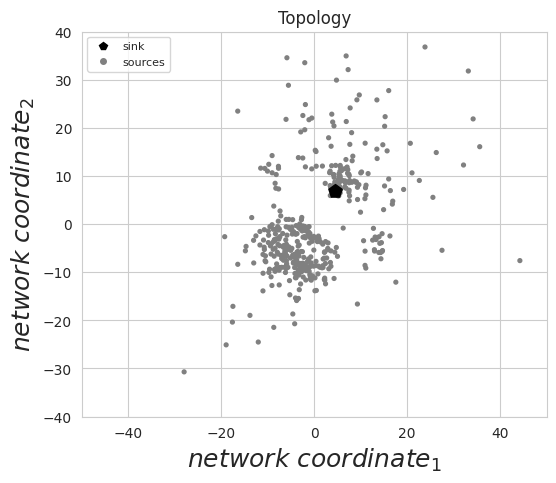

In [15]:
X_dim_def = [-50, 50]
Y_dim_def = [-40, 40]

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 5))
ax1 = util.plot_topology(ax1, prim_df)

ax1.set_xlim(X_dim_def)
ax1.set_ylim(Y_dim_def)

X_dim = ax1.get_xlim()
Y_dim = ax1.get_ylim()

plt.savefig("plots/fit/fit_ncs_plain.svg", bbox_inches="tight")

plt.show()

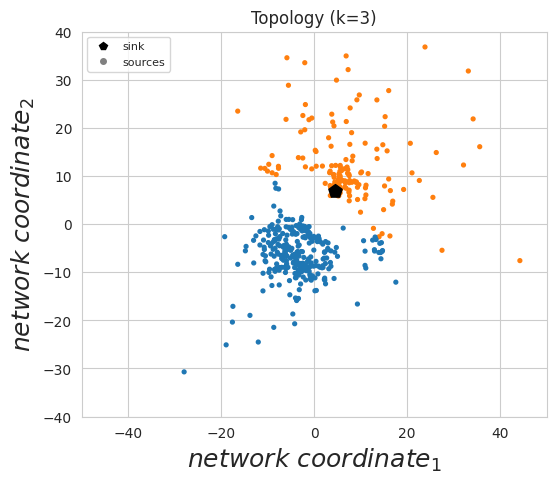

In [16]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 5))

ax1 = util.plot_topology(ax1, prim_df, colors, 'Topology (k=' + str(opt_k) + ")")

ax1.set_xlim(X_dim_def)
ax1.set_ylim(Y_dim_def)

# plt.savefig("plots/fit/fit_ncs_colored.svg", bbox_inches="tight")

plt.show()

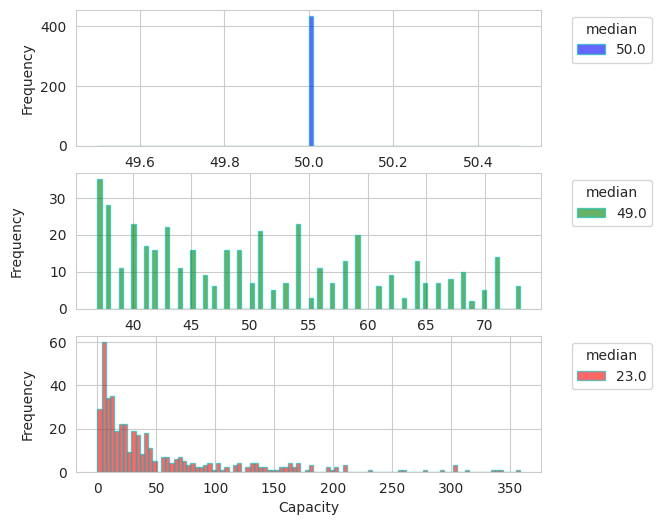

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6))

i = 100
prim_df["capacity_" + str(i)].plot.hist(ax=ax1, bins=100, alpha=0.6, color='b', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

i = 50
prim_df["capacity_" + str(i)].plot.hist(ax=ax2, bins=100, alpha=0.6, color='g', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

i = 1
prim_df["capacity_" + str(i)].plot.hist(ax=ax3, bins=100, alpha=0.6, color='r', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

ax1.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.set_xlabel("Capacity")

# Set y-axis label with padding
ax2.set_ylabel("Frequency", labelpad=18)
ax3.set_ylabel("Frequency", labelpad=10)
plt.savefig("plots/sim_1000/capacity_dist.svg", bbox_inches="tight")

plt.show()

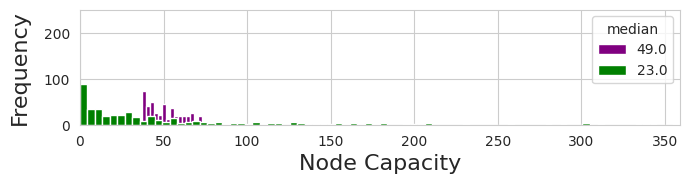

In [18]:
fig, (merged_ax) = plt.subplots(1, 1, figsize=(7, 2))

i = 50
prim_df["capacity_" + str(i)].plot.hist(ax=merged_ax, bins=15, alpha=1, color='purple',
                                        label=prim_df["capacity_" + str(i)].median())

#i = 10
#prim_df["capacity_"+str(i)].plot.hist(ax=merged_ax, bins=40, alpha=1, color='orange', label=prim_df["capacity_"+str(i)].median())

i = 1
prim_df["capacity_" + str(i)].plot.hist(ax=merged_ax, bins=80, alpha=1, color='green',
                                        label=prim_df["capacity_" + str(i)].median())

merged_ax.legend(title='median', loc='upper right')
merged_ax.set_xlabel("Node Capacity")

# Set y-axis label with padding
merged_ax.set_ylabel("Frequency", labelpad=10)

# Set the same x-axis limits for both histograms
xlim = (prim_df["capacity_1"].min(), prim_df["capacity_1"].max())
merged_ax.set_xlim(xlim)
merged_ax.set_ylim([0, 250])

merged_ax.yaxis.label.set_size(16)
merged_ax.xaxis.label.set_size(16)
#merged_ax.tick_params(axis='x', labelsize=20)

# Adjust figure layout for better display
fig.tight_layout()

plt.savefig("plots/fit/capacity_dist.svg", bbox_inches="tight")
plt.show()

Medians from  50  to  25


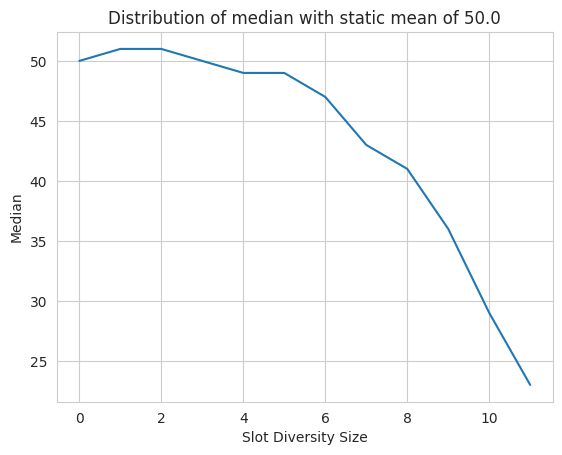

In [19]:
medians = []
mean = np.floor(prim_df["capacity_" + str(1)].mean())

for col in slot_columns:
    medians.append(prim_df[col].median())

medians = np.array(medians)
plt.plot(np.arange(len(medians)), medians)

first_med_label = "50"
last_med_label = "25"
print("Medians from ", first_med_label, " to ", last_med_label)

#print(load_dict)
plt.title("Distribution of median with static mean of " + str(mean))
plt.ylabel("Median")
plt.xlabel("Slot Diversity Size")
plt.show()

### Experiment 1: Send all data directly to coordinator


In [20]:
#first node is the coordinator
latency_hist = np.zeros(device_number)

for i in range(0, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    latency_hist[i] = np.linalg.norm(coords[i] - c_coords)

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    #coordinator receives 1 packet from each
    received_packets_hist[0] = received_packets_hist[0] + 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)
print(df_stats)
eval_matrix["dt"] = df_stats.copy()

     latency_distribution  received_packets
0                0.000000             432.0
1               16.300028               0.0
2               10.804166               0.0
3               10.753568               0.0
4                7.865801               0.0
..                    ...               ...
428             14.453032               0.0
429             15.791470               0.0
430             15.032201               0.0
431             13.072839               0.0
432             14.977569               0.0

[433 rows x 2 columns]


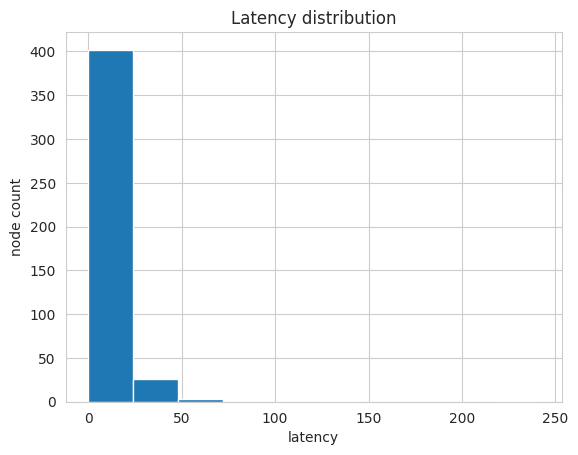

In [21]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
plt.show()

In [22]:
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"]
print("Distribution of workload: ", 1, "/", device_number, "=", round(len(df_packets) / device_number * 100, 5), "%")

Distribution of workload:  1 / 433 = 0.23095 %


### Experiment 1: LEACH Protocol

In [23]:
seed = 10
np.random.seed(seed)
latency_hist_sum = None
received_packets_hist_sum = None
leach_runs = 20
run = 1
df_stats_leach = []
num_leach_clusters = int(0.1*device_number)

for i in range(leach_runs):
    print("LEACH run", run)
    if run == leach_runs:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords, seed=seed)
    else:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords)

    leach_labels, ch_indexes, latency_hist, received_packets_hist = leachSolver.leachClustering()

    if latency_hist_sum is None:
        latency_hist_sum = latency_hist
    else:
        latency_hist_sum = latency_hist_sum + latency_hist

    statistics = {"latency_distribution": latency_hist,
                  "received_packets": received_packets_hist}
    df_stats = pd.DataFrame(statistics)
    df_stats_leach.append(df_stats.copy())
    run = run + 1

print("Number of clusters = ", len(ch_indexes))
print(ch_indexes)

LEACH run 1
LEACH run 2
LEACH run 3
LEACH run 4
LEACH run 5
LEACH run 6
LEACH run 7
LEACH run 8
LEACH run 9
LEACH run 10
LEACH run 11
LEACH run 12
LEACH run 13
LEACH run 14
LEACH run 15
LEACH run 16
LEACH run 17
LEACH run 18
LEACH run 19
LEACH run 20
Number of clusters =  43
[293, 17, 220, 248, 296, 8, 106, 237, 417, 252, 422, 143, 335, 416, 83, 18, 267, 251, 168, 39, 128, 382, 185, 23, 216, 72, 309, 182, 196, 146, 424, 346, 135, 234, 90, 352, 156, 339, 186, 69, 394, 123, 226]


In [24]:
df_stats

,latency_distribution,received_packets
0,0.000000,43.0
1,18.655511,0.0
2,10.908605,0.0
3,10.503399,0.0
4,16.039567,0.0
...,...,...
428,13.953163,0.0
429,16.049867,0.0
430,17.049867,0.0
431,24.091816,0.0


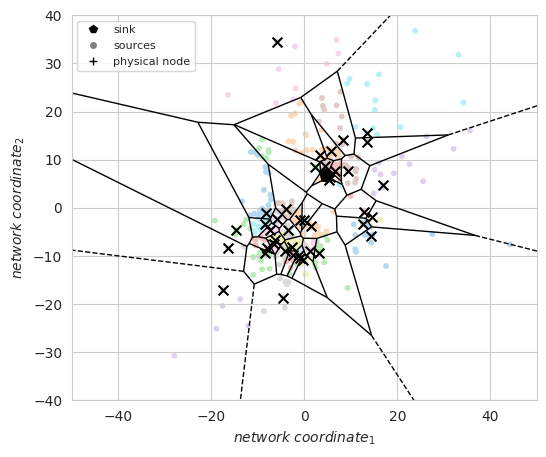

In [25]:
fig = plt.figure(figsize=(6, 5)).gca()
cluster_head_coords = coords[ch_indexes]

leach_color_list = sns.color_palette(n_colors=num_leach_clusters)
leach_colors = np.asarray(leach_color_list.as_hex())

fig.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=100)
fig.scatter(cluster_head_coords[:, 0], cluster_head_coords[:, 1], s=50, color="black", marker="x", zorder=2)
fig.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.3) for x in leach_colors[leach_labels]],
            zorder=-1)

plt.legend(handles=[coordinator_label, worker_label, ch_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

vor = Voronoi(cluster_head_coords)
voronoi_plot_2d(vor, ax=fig, point_size=16, color="red", show_vertices=False, show_points=False)

plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.savefig("plots/fit/leach.svg")
plt.show()

count    433.000000
mean      16.812790
std       15.609759
min        0.000000
25%       11.503399
50%       16.172295
75%       18.999351
max      253.604529
Name: latency_distribution, dtype: float64


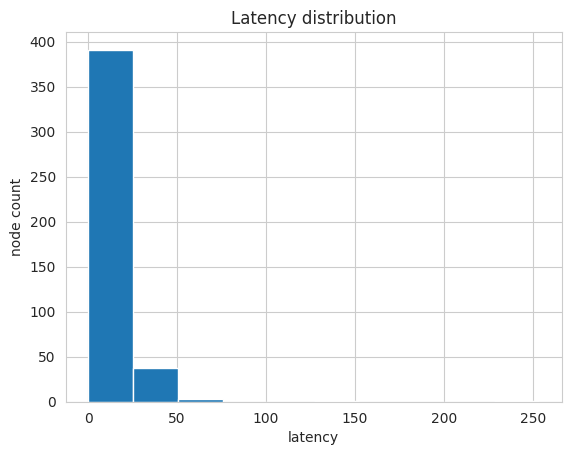

In [26]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

In [27]:
eval_matrix["leach"] = df_stats.copy()

### Experiment 2a: NEMO Aggregation with Density-based Grouping

### Identify parameters

In [30]:
# fixed params
max_levels = 50
slot_col = "capacity_100"
weight_col = "weight"

# dynamic params
num_points = 9
start = 0.1
end = 0.9
hyperparam_values_1 = np.linspace(start, end, num_points)
hyperparam_values_2 = np.linspace(start, end, num_points)
X, Y = np.meshgrid(hyperparam_values_1, hyperparam_values_2)

# Initialize an array to store performance values
perc_lat_values = np.zeros_like(X)
mean_lat_values = np.zeros_like(X)

for i in range(num_points):
    for j in range(num_points):
        eval_dict, df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, [slot_col], weight_col, merge_factor=X[i, j], step_size=Y[i, j], max_levels=max_levels, with_eval=True)
        sv = eval_dict[slot_col]["latency_distribution"].sort_values()
        perc_lat = round(sv.quantile(0.9), 2)
        mean_lat = round(sv.mean(), 2)
        print(perc_lat, mean_lat)

        perc_lat_values[i, j] = perc_lat
        mean_lat_values[i, j] = mean_lat

Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.1
Evaluating for capacity_100
40.82 28.43
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.2
Evaluating for capacity_100
40.82 28.43
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.30000000000000004
Evaluating for capacity_100
40.82 28.43
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.4
Evaluating for capacity_100
40.82 28.43
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.5
Evaluating for capacity_100
40.82 28.43
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.6
Evaluating for capacity_100
40.82 28.43
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.7000000000000001
Evaluating for capacity_100
76.55 54.3
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.8
Evaluating for capacity_10

merge factor and step size for minimum latency (90P): (X=0.7000000000000001, Y=0.6) 27.47
merge factor and step size for minimum latency (mean): (X=0.7000000000000001, Y=0.6) 18.83


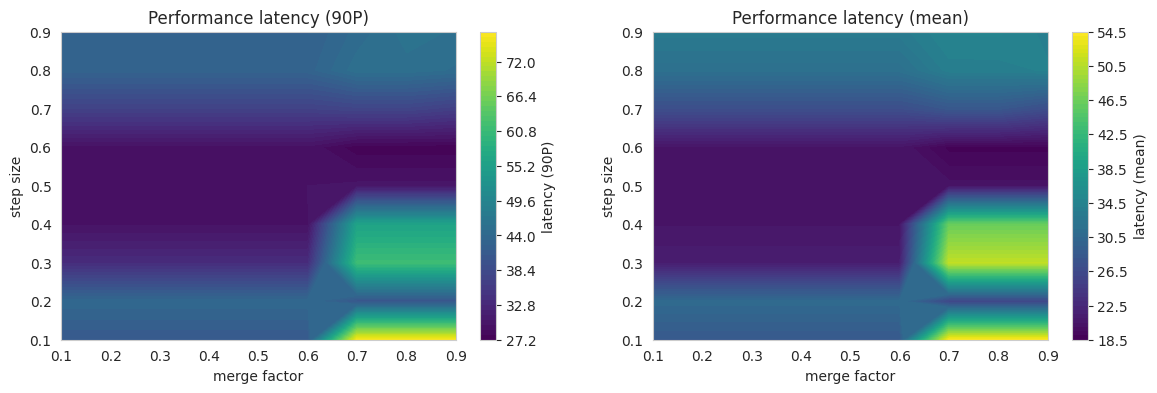

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

for i, values in enumerate([perc_lat_values, mean_lat_values]):
    if i == 0:
        label = "latency (90P)"
    elif i == 1:
        label = "latency (mean)"
    else:
        label = "undefined"
        
    # Find the indices of the minimum Z value
    min_index = np.unravel_index(np.argmin(values), values.shape)
    # Use the indices to get the corresponding X and Y values
    min_X = X[min_index]
    min_Y = Y[min_index]
    print(f"merge factor and step size for minimum {label}: (X={min_X}, Y={min_Y})", values[min_index])
    
    # Create a contour plot
    ax = axs[i]
    contour = ax.contourf(X, Y, values, levels=80, cmap='viridis')

    # Create a colorbar and set the label
    colorbar = plt.colorbar(contour)
    colorbar.set_label(label)
    
    ax.set_title(f"Performance {label}")
    ax.set_xlabel('merge factor')
    ax.set_ylabel('step size')
    
plt.show()

In [32]:
param_dict = {
    "weight_1": {"merge_factor": 0.1, "step_size": 0.9},
    "weight_2": {"merge_factor": 0.1, "step_size": 0.9},
    "weight": {"merge_factor": 0.7, "step_size": 0.6}
}

In [33]:
# for the eval for weights regarding latency
weight_cols = ["weight_2", "weight"]
for weight_col in weight_cols:
    eval_name = "nemo_dc" + "_" + weight_col
    eval_matrix[eval_name], df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, ["capacity_100", "capacity_1"], weight_col, 
                                                                           merge_factor=param_dict[weight_col]["merge_factor"], step_size=param_dict[weight_col]["step_size"], with_eval=True)

Starting nemo for: c=capacity_100, w=weight_2, l=20, step_size=0.9, merge_factor=0.1
Evaluating for capacity_100
Starting nemo for: c=capacity_1, w=weight_2, l=20, step_size=0.9, merge_factor=0.1
Evaluating for capacity_1
Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.6, merge_factor=0.7
Evaluating for capacity_100
Starting nemo for: c=capacity_1, w=weight, l=20, step_size=0.6, merge_factor=0.7
Evaluating for capacity_1


In [34]:
# for the plots and vanilla NEMO
eval_name = "nemo_dc"
slot_col = "capacity_100"
weight_col = "weight_1"
df_dict_1, opt_dict_1, limits_dict_1 = evaluate_nemo(prim_df, [slot_col], weight_col, max_levels=1, merge_factor=param_dict[weight_col]["merge_factor"], step_size=param_dict[weight_col]["step_size"], with_eval=False)
eval_matrix[eval_name], df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, slot_columns, weight_col, merge_factor=param_dict[weight_col]["merge_factor"], step_size=param_dict[weight_col]["step_size"], with_eval=True)

Starting nemo for: c=capacity_100, w=weight_1, l=1, step_size=0.9, merge_factor=0.1
Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.9, merge_factor=0.1
Evaluating for capacity_100
Starting nemo for: c=capacity_90, w=weight_1, l=20, step_size=0.9, merge_factor=0.1
Evaluating for capacity_90
Starting nemo for: c=capacity_80, w=weight_1, l=20, step_size=0.9, merge_factor=0.1
Evaluating for capacity_80
Starting nemo for: c=capacity_70, w=weight_1, l=20, step_size=0.9, merge_factor=0.1
Evaluating for capacity_70
Starting nemo for: c=capacity_60, w=weight_1, l=20, step_size=0.9, merge_factor=0.1
Evaluating for capacity_60
Starting nemo for: c=capacity_50, w=weight_1, l=20, step_size=0.9, merge_factor=0.1
Evaluating for capacity_50
Starting nemo for: c=capacity_40, w=weight_1, l=20, step_size=0.9, merge_factor=0.1
Evaluating for capacity_40
Starting nemo for: c=capacity_30, w=weight_1, l=20, step_size=0.9, merge_factor=0.1
Evaluating for capacity_30
Starting nemo for: c=capac

In [35]:
df = df_dict[slot_col]
df

,oindex,x,y,type,cluster,total_weight,used_weight,total_capacity,free_capacity,level,parent,latency,load
0,0,4.56190,6.84360,coordinator,-1,0,0,50,40,2,0,0.000000,10
1,1,-4.17850,-6.91490,worker,0,12,1,50,50,0,142,16.906565,0
2,2,-1.26250,-2.25620,worker,0,1,1,50,50,0,139,11.858825,0
3,3,-0.14588,-2.82470,worker,0,2,1,50,50,0,139,11.855423,0
4,4,6.22700,-0.84394,worker,0,3,1,50,50,0,139,9.103918,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,428,14.10200,-4.01350,worker,0,2,1,50,50,0,39,14.457058,0
429,429,13.88500,-5.90200,worker,0,2,1,50,50,0,39,15.791553,0
430,430,12.97500,-5.61380,worker,0,1,1,50,50,0,39,15.033767,0
431,431,-8.41010,8.46420,worker,0,1,1,50,50,0,143,13.823958,0


In [36]:
df[df["parent"] == df["oindex"]]

,oindex,x,y,type,cluster,total_weight,used_weight,total_capacity,free_capacity,level,parent,latency,load
0,0,4.5619,6.8436,coordinator,-1,0,0,50,40,2,0,0.0,10


In [37]:
df[df["parent"] == 0]

,oindex,x,y,type,cluster,total_weight,used_weight,total_capacity,free_capacity,level,parent,latency,load
0,0,4.5619,6.8436,coordinator,-1,0,0,50,40,2,0,0.000000,10
10,10,4.3011,7.8095,worker,1,1,1,50,28,1,0,1.000490,22
39,39,5.2869,5.8755,worker,1,3,1,50,0,1,0,1.209480,50
126,126,4.1122,6.7365,worker,1,2,1,50,0,1,0,0.462278,50
133,133,4.6754,7.3990,worker,1,7,1,50,1,1,0,0.566879,49
137,137,3.4592,5.9184,worker,1,6,1,50,0,1,0,1.439424,50
139,139,4.4138,7.4448,worker,1,1,1,50,0,1,0,0.619173,50
140,140,4.5845,7.8056,worker,1,1,1,50,0,1,0,0.962265,50
142,142,5.0970,5.8641,worker,1,2,1,50,0,1,0,1.116133,50
143,143,4.9078,6.6722,worker,1,7,1,50,0,1,0,0.386037,50


In [38]:
# check -> should be empty
df_overloaded = df.groupby(['parent'])['used_weight'].sum().copy().reset_index()
df_join = df[["oindex", "total_capacity", "free_capacity"]]
result = pd.merge(df_join, df_overloaded, left_on='oindex', right_on='parent', how='inner')
result["delta"] = result["total_capacity"] - result["used_weight"]
result[result["delta"] < 0]

,oindex,total_capacity,free_capacity,parent,used_weight,delta


In [39]:
# check -> should be empty
result[result["delta"] != result["free_capacity"]]

,oindex,total_capacity,free_capacity,parent,used_weight,delta


In [40]:
result

,oindex,total_capacity,free_capacity,parent,used_weight,delta
0,0,50,40,0,10,40
1,10,50,28,10,22,28
2,39,50,0,39,50,0
3,126,50,0,126,50,0
4,133,50,1,133,49,1
5,137,50,0,137,50,0
6,139,50,0,139,50,0
7,140,50,0,140,50,0
8,142,50,0,142,50,0
9,143,50,0,143,50,0


In [41]:
#create greedy aggregation tree
cluster_coords = centroids
cluster_coords_with_crd = np.column_stack((c_coords, cluster_coords.T)).T

mst = prim_mst(cluster_coords_with_crd)

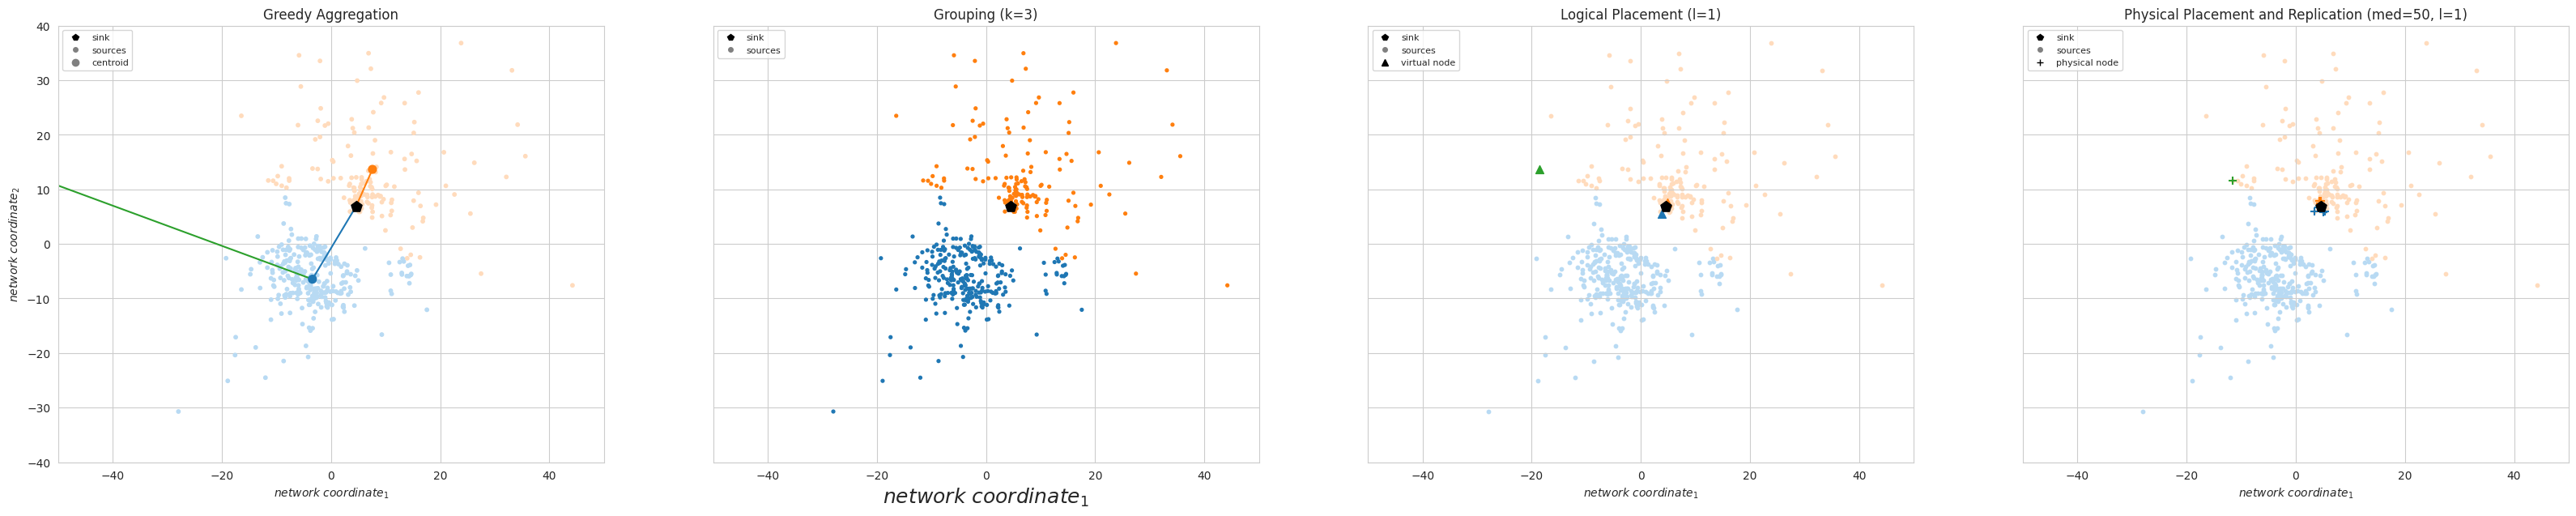

In [43]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")
lval = 0.28
labels = prim_df["cluster"]

# plot greedy approach from MST
for i in range(1, len(mst)):
    point1 = cluster_coords_with_crd[i]
    point2 = cluster_coords_with_crd[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    ax1.plot(x_values, y_values, zorder=2, color=colors[i - 1])

ax1.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=10)
ax1.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:len(cluster_coords)], zorder=3)
# in case all coords shall be plotted
ax1.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, lval) for x in colors[labels]])

lcentroid = Line2D([], [], color="blue", marker='o', linestyle='None', label='centroid')
ax1.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1),
           fontsize=8)

ax1.set_xlabel('$network$ $coordinate_1$')
ax1.set_ylabel('$network$ $coordinate_2$')
ax1.set_title('Greedy Aggregation')

#plot grouping
util.plot_topology(ax2, prim_df, colors, title='Grouping (k=' + str(opt_k) + ")")

# TODO: unify the two below plots into a single one
#plot logical nodes (optima) of different groups
# util.plot2(ax3, prim_df, df_dict[slot_col], colors, lval=lval, show_centroids=True)
util.plot_optimum(ax3, prim_df, opt_dict[slot_col], colors, lval=lval, plot_centroid=False, plot_lines=False)
# plot physical nodes
util.plot(ax4, prim_df, df_dict_1[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=False)

plt.xlim(X_dim)
plt.ylim(Y_dim)
ax3.set_title("Logical Placement (l=1)")
ax4.set_title("Physical Placement and Replication (med=" + first_med_label + ", l=1)")

plt.savefig("plots/fit/nemo_phases.svg", bbox_inches="tight")
plt.show()

Starting nemo for: c=capacity_100, w=weight_1, l=1, step_size=0.9, merge_factor=0.1
Starting nemo for: c=capacity_100, w=weight_1, l=2, step_size=0.9, merge_factor=0.1
Starting nemo for: c=capacity_100, w=weight_1, l=5, step_size=0.9, merge_factor=0.1
Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.9, merge_factor=0.1


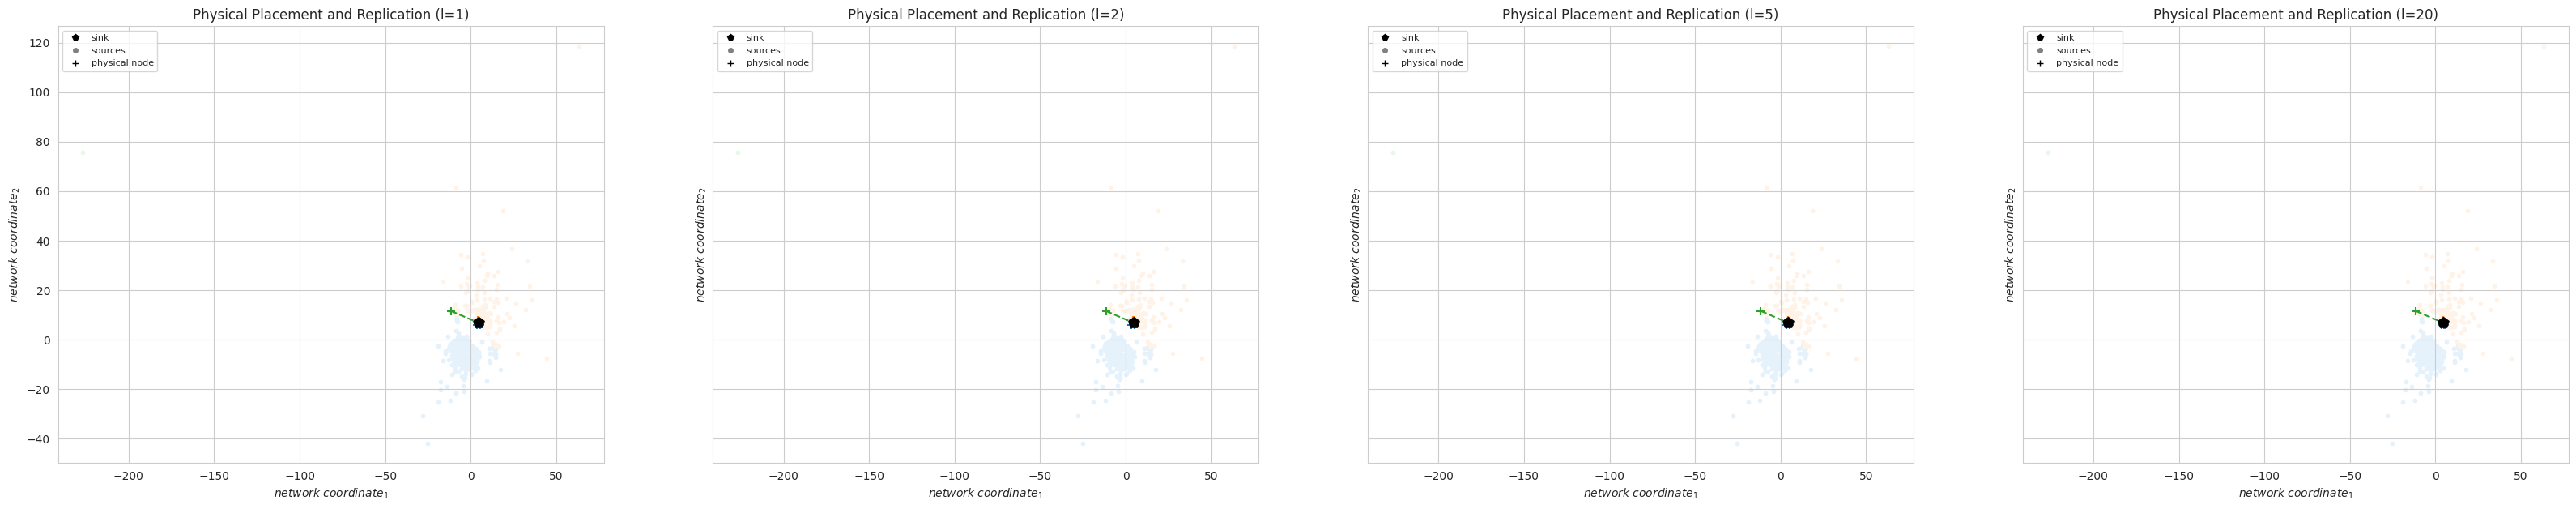

In [44]:
levels = [1, 2, 5, 20]
fig, axs = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")
lval = 0.1

for i, level in enumerate(levels):
    df_dict_i, opt_dict_i, limits_dict_i = evaluate_nemo(prim_df, [slot_col], weight_col, merge_factor=param_dict[weight_col]["merge_factor"], step_size=param_dict[weight_col]["step_size"], max_levels=level, with_eval=False)
    util.plot(axs[i], prim_df, df_dict_i[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=True)
    axs[i].set_title("Physical Placement and Replication (l=" + str(level) + ")")

plt.show()

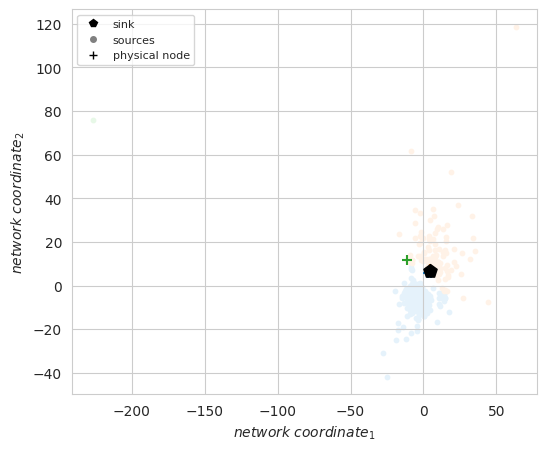

In [45]:
ax = plt.figure(figsize=(6, 5)).gca()

#uncomment this to plot nemo grouping
#ax2.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.2) for x in colors[labels]], zorder=-1)
#ax2.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:no_clusters], zorder=2)
#ax2.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=1)
#ax2.set_title('Grouping (k=' + str(opt_k) + ")")
#fig.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

#uncomment this for nemo placement
util.plot(ax, prim_df, df_dict_1[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=False)

#uncomment this for nemo redistribution
#util.plot(fig, new_paths_flat[slot_col], agg_dict_flat[slot_col], c_coords, cluster_coords, coords, colors, labels, changed_labels=reassigned_clussters, lval=lval)


ax.set_xlabel('$network$ $coordinate_1$')
ax.set_ylabel('$network$ $coordinate_2$')

plt.savefig("plots/fit/nemo_placement.svg", bbox_inches="tight")

Distribution of workload:  3.4642 %


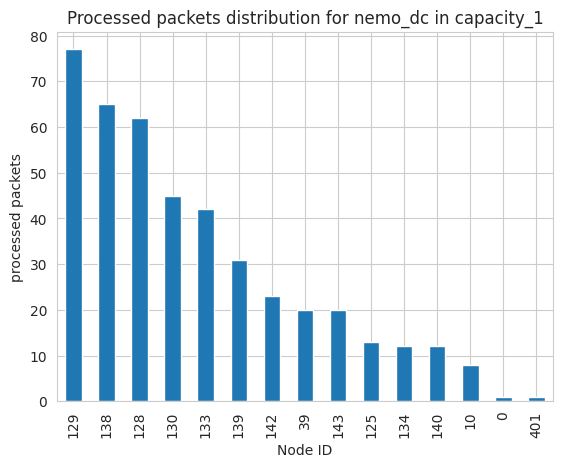

In [46]:
eval_col = list(eval_matrix[eval_name])[-1]
df_stats = eval_matrix[eval_name][eval_col]
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"].sort_values(ascending=False)
df_packets.plot.bar()

print("Distribution of workload: ", round(len(df_packets) / device_number * 100, 4), "%")
plt.xlabel("Node ID")
plt.ylabel("processed packets")
plt.title("Processed packets distribution for " + eval_name + " in " + str(eval_col))
plt.show()

### Experiment 3: Calculating the minimimal chain which is equivallent to the TSP
#### Corresponds to to the optimal chain of chain-based protocol solutions like PEGASIS or CREEC

In [47]:
# the adjacency matrix for the plane
df = prim_df.copy()
t_coords = coords[0::]
solver = AnnealingSolver()
route, valueBest, nCities, recordBest, recordNow = solver.solve_tsp(t_coords)

i:0, t(i):10.00, valueNow:4760.0, valueBest:4633.0
i:10, t(i):3.49, valueNow:3988.0, valueBest:3979.0
i:20, t(i):1.22, valueNow:3490.0, valueBest:3489.0
i:30, t(i):0.42, valueNow:3112.0, valueBest:3112.0
i:40, t(i):0.15, valueNow:2885.0, valueBest:2885.0
i:50, t(i):0.05, valueNow:2743.0, valueBest:2743.0
i:60, t(i):0.02, valueNow:2651.0, valueBest:2651.0


In [48]:
print(route)

[407 426 366 381 383 400 348 352 286 275 364 295 293 250 261 309 145 229
 219 205 210 216 201 167 285 161 329 305 264 321 231 226 292 175 330 282
 283 341 315 310 331 265 212 334 181 278 324 262 370 389 391 162 240 185
 152 203 320 206 284 254 323 169 174 249 244 147 193 171 241 239 266 260
 232 376 176 325 316 328 300 357 362 351 165 269 179 322 158 279 202 263
 183 144 288 221 166   1 380 354  30  21  11 428 409 429 299 307 267 378
 246 337 385   4  90   6 411 418 424 410  95 133 125 140 137 346 395 386
 384 345 382 390 374  39 126 131 128 127 142  47 107  45  12  88  34   8
   7  61 132  23  74 104  82 109 103 118  20  52  97  33  89  27  38  96
 106  58 117  59  84  40  55 105  41 123  68 119  66  91  69  37  46  36
  94  81  15  79 102  44  73  48  57  42  85  83  53  28  87  77   5  24
  10 401 427 122  67  62 108 134  29  72  78 143   0  22  49  64  50  65
 111  25  99  92  80  32  16  93  14  19 100  56  35  31 124 101  75  76
 406 414  17  13  63 421 387 431 423 405 413  71  2

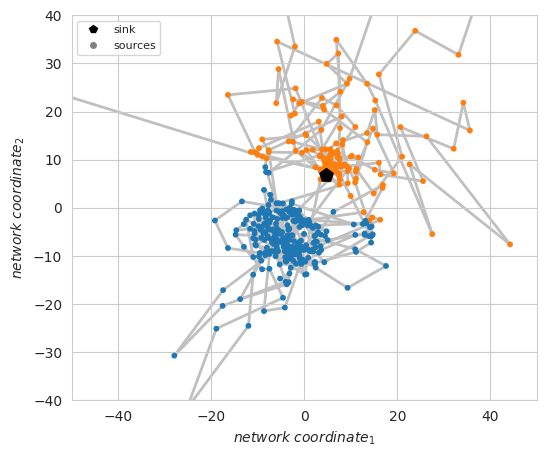

In [49]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(0, len(route) - 1):
    point1 = coords[route[i]]
    point2 = coords[route[i + 1]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=colors[labels], s=10, ax=fig)
plt.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/fit/chain_50n.svg", bbox_inches="tight")
plt.show()

In [50]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
received_packets_hist = np.zeros(device_number)
ind_cor = np.where(route == 0)[0][0]
print("Coordinator is on place ", ind_cor, " in route.")

for i in range(0, len(route)):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = []
    if i < ind_cor:
        lat_route = route[i:ind_cor + 1]
    elif i > ind_cor:
        lat_route = route[i:ind_cor - 1:-1]
    else:
        continue

    start_idx = lat_route[0]
    received_packets_hist[lat_route[1]] += 1
    for j in range(1, len(lat_route)):
        end_idx = lat_route[j]
        dist = dist + np.linalg.norm(coords[start_idx] - coords[end_idx])
        start_idx = end_idx
    latency_hist[i] = dist

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)

Coordinator is on place  210  in route.


In [51]:
print(df_stats["received_packets"])

0      2.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
428    1.0
429    1.0
430    0.0
431    1.0
432    1.0
Name: received_packets, Length: 433, dtype: float64


count     433.000000
mean      848.674869
std       472.363054
min         0.000000
25%       480.660915
50%       833.024073
75%      1224.499966
max      1685.817862
Name: latency_distribution, dtype: float64


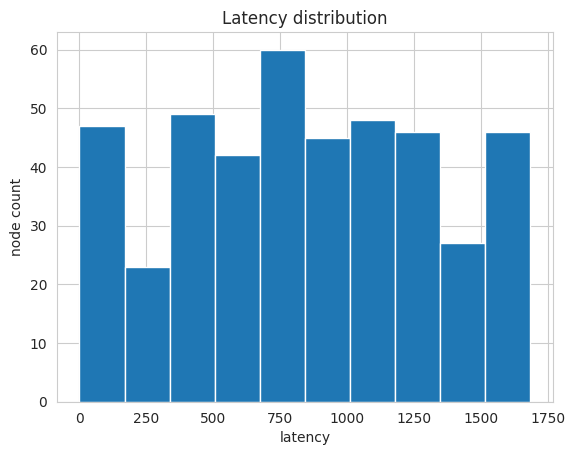

In [52]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

count    433.000000
mean       0.997691
std        0.083301
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: received_packets, dtype: float64


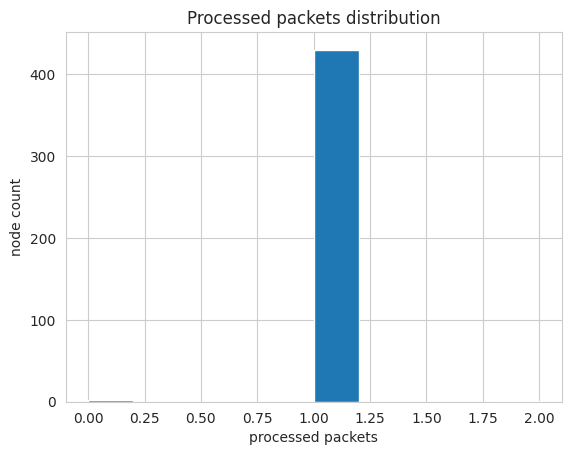

In [53]:
df_stats["received_packets"].hist()
plt.xlabel("processed packets")
plt.ylabel("node count")
plt.title("Processed packets distribution")
print(df_stats["received_packets"].describe())

eval_matrix["chain"] = df_stats.copy()

In [54]:
np.where(received_packets_hist > 1)

(array([0]),)

### Experiment 4: Calculating the minimum spanning tree like in PEDAP

In [55]:
df = prim_df.copy()
mst = prim_mst(coords)

In [56]:
print(mst)

[-1, 206, 400, 345, 384, 112, 90, 112, 34, 68, 130, 53, 7, 9, 21, 33, 97, 66, 21, 6, 12, 88, 61, 95, 45, 60, 72, 36, 14, 78, 24, 38, 14, 81, 91, 31, 89, 93, 96, 128, 55, 49, 65, 51, 55, 114, 93, 107, 85, 99, 63, 110, 32, 28, 67, 75, 102, 59, 59, 42, 115, 104, 26, 105, 105, 48, 108, 57, 123, 64, 134, 85, 70, 50, 132, 84, 71, 80, 70, 37, 88, 16, 78, 69, 73, 50, 11, 77, 20, 46, 97, 49, 41, 69, 15, 74, 27, 32, 57, 103, 81, 35, 79, 118, 82, 8, 54, 92, 62, 22, 119, 25, 95, 413, 23, 110, 106, 58, 109, 17, 122, 106, 98, 103, 101, 130, 0, 125, 143, 125, 139, 30, 82, 0, 127, 141, 128, 126, 136, 133, 10, 129, 39, 0, 288, 165, 271, 201, 174, 198, 208, 185, 298, 178, 291, 170, 173, 148, 194, 302, 259, 285, 177, 166, 249, 253, 156, 193, 311, 211, 161, 147, 322, 322, 334, 284, 316, 328, 157, 289, 269, 196, 242, 320, 313, 152, 195, 266, 236, 214, 250, 299, 317, 227, 313, 220, 265, 217, 189, 218, 205, 167, 184, 183, 208, 224, 180, 306, 235, 254, 200, 338, 312, 229, 213, 210, 205, 171, 150, 149, 146, 33

In [57]:
routes = createRoutes(mst)
print(routes[3])

[345, 389, 382, 392, 2, 400, 390, 349, 343, 348, 374, 361, 397, 363, 352, 362, 310, 287, 360, 296, 314, 256, 282, 283, 190, 250, 293, 301, 326, 275, 290, 364, 341, 286, 406, 414, 431, 423, 425, 421, 111, 25, 60, 115, 110, 119, 17, 66, 108, 62, 26, 72, 70, 134, 127, 125, 130, 139, 133, 0]


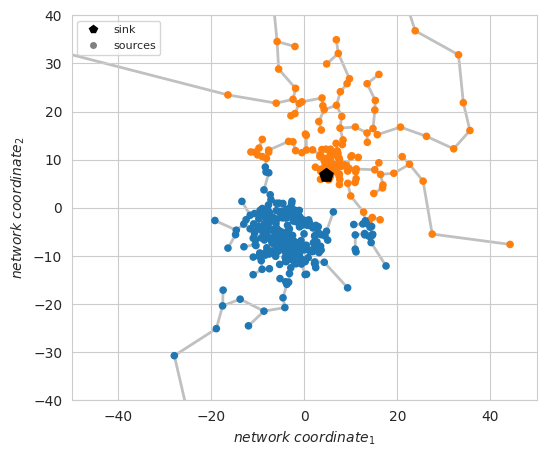

In [58]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(1, len(mst)):
    point1 = coords[i]
    point2 = coords[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=colors[labels], ax=fig)
fig.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/fit/mst.svg", bbox_inches="tight")
plt.show()

In [59]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
for i in range(1, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = routes[i]
    start = i
    for j in range(0, len(lat_route)):
        end = lat_route[j]
        dist = dist + np.linalg.norm(coords[start] - coords[end])
        start = end
    latency_hist[i] = dist

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    received_packets_hist[mst[i]] += 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)

count    433.000000
mean      37.461694
std       22.744198
min        0.000000
25%       23.050038
50%       43.481998
75%       49.674333
max      261.640555
Name: latency_distribution, dtype: float64


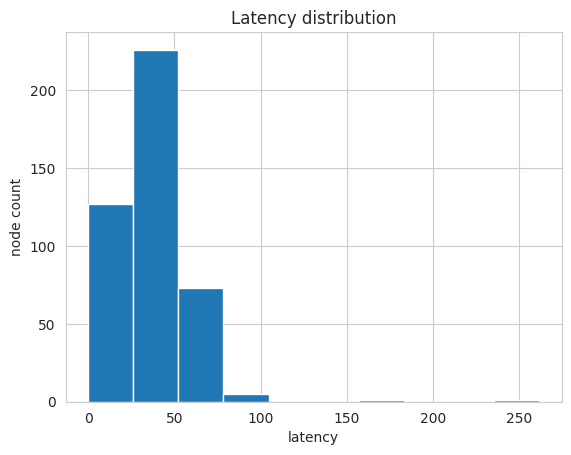

In [60]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

Distribution of workload:  79.2148 %


Text(0.5, 1.0, 'Processed packets distribution')

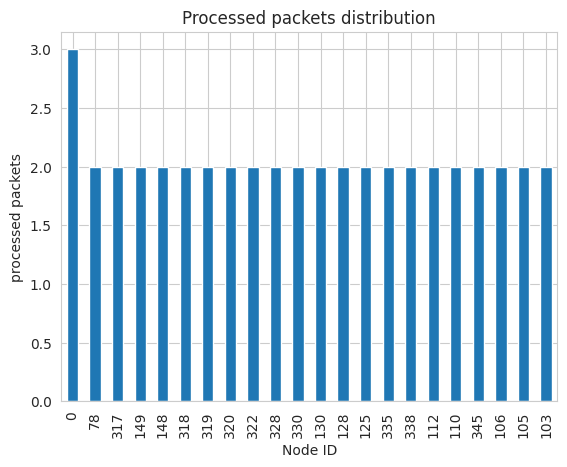

In [61]:
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"].sort_values(ascending=False)
print("Distribution of workload: ", round(len(df_packets) / device_number * 100, 4), "%")

df_packets = df_packets.head(int(round(device_number * 0.05)))
df_packets.plot.bar()

plt.xlabel("Node ID")
plt.ylabel("processed packets")
plt.title("Processed packets distribution")

In [62]:
eval_matrix["mst"] = df_stats.copy()

## Evaluation

In [63]:
eval_matrix.keys()

dict_keys(['dt', 'leach', 'nemo_dc_weight_2', 'nemo_dc_weight', 'nemo_dc', 'chain', 'mst'])

In [64]:
eval_matrix["nemo_dc"].keys()

dict_keys(['capacity_100', 'capacity_90', 'capacity_80', 'capacity_70', 'capacity_60', 'capacity_50', 'capacity_40', 'capacity_30', 'capacity_20', 'capacity_10', 'capacity_5', 'capacity_1'])

In [65]:
aggregation_fams = ["dt", "leach", "mst", "chain"]
heterogen_appr = ['nemo_dc', 'nemo_dc_weight_2', 'nemo_dc_weight']

#### Latency

In [66]:
heterogen_appr

['nemo_dc', 'nemo_dc_weight_2', 'nemo_dc_weight']

In [67]:
ecolors, elight_colors, epalette = util.get_color_list(20)

eval_colors = {
    "dt": ecolors[0],
    "leach": ecolors[1],
    "mst": ecolors[2],
    "chain": ecolors[3],
    "nemo": ecolors[4],
    "nemo_base": ecolors[4],
    "nemo_dc_base": ecolors[4],
    "NEMO_base": ecolors[4],
    "nemo_rc": ecolors[5],
    "nemo_rc_base": ecolors[5],
    "nemo (rdm groups)_base": ecolors[5],
    "nemo_dc": ecolors[6],
    "NEMO+redistribution": ecolors[6],
    "nemo_pen": ecolors[7],
    "nemo_pen_base": ecolors[8],
    "nemo_dc_weight_2": ecolors[9],
    "nemo_dc_weight": ecolors[10]
}

renaming_dict = {
    "nemo_dc": "nemo (w=1,",
    "nemo_dc_weight_2": "nemo (w=2,",
    "nemo_dc_weight": "nemo (w=ln[1, 50],",
    "capacity_100": "m=" + first_med_label,
    "capacity_1": "m=" + last_med_label
}


In [68]:
eval_matrix["dt"]["latency_distribution"].mean()

15.494777665579779

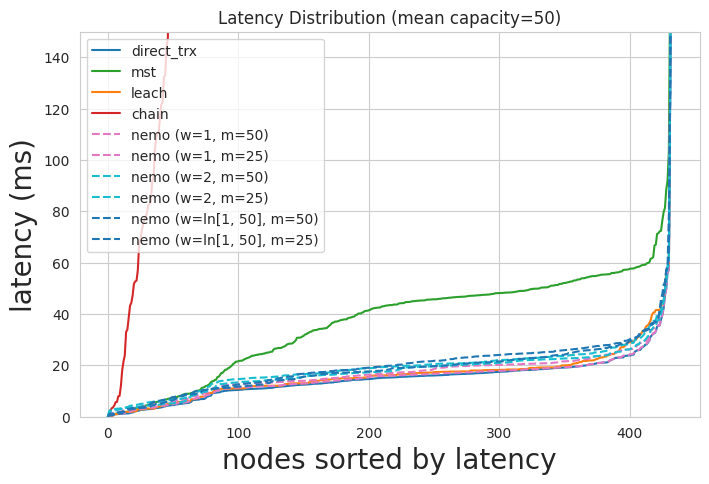

Means:  {'dt': 15.49, 'mst': 37.46, 'leach': 16.81, 'chain': 848.67, 'nemo (w=1, m=50)': 15.94, 'nemo (w=1, m=25)': 17.52, 'nemo (w=2, m=50)': 18.4, 'nemo (w=2, m=25)': 19.33, 'nemo (w=ln[1, 50], m=50)': 18.83, 'nemo (w=ln[1, 50], m=25)': 20.06}
Quantiles:  {'dt': 22.87, 'mst': 56.12, 'leach': 24.89, 'chain': 1533.59, 'nemo (w=1, m=50)': 22.94, 'nemo (w=1, m=25)': 24.69, 'nemo (w=2, m=50)': 24.98, 'nemo (w=2, m=25)': 26.96, 'nemo (w=ln[1, 50], m=50)': 27.47, 'nemo (w=ln[1, 50], m=25)': 28.54}


In [71]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}

#plot baselines
for l in ["dt", "mst", "leach", "chain"]:
    orl = l
    sv = eval_matrix[l]["latency_distribution"].sort_values()
    #print("Mean latency ", l, ": ", round(eval_matrix[l]["latency_distribution"].mean(), 2))
    quant_dict[l] = round(eval_matrix[l]["latency_distribution"].quantile(0.9), 2)
    mean_dict[l] = round(eval_matrix[l]["latency_distribution"].mean(), 2)

    if l == "dt":
        l = "direct_trx"
    sv.plot(ax=ax1, linestyle="-", use_index=False, label=l, color=eval_colors[orl])

for approach in heterogen_appr:
    cl = approach
    emat = eval_matrix[approach]

    for capacity, df in emat.items():
        if capacity not in ["capacity_100", "capacity_1"]:
            continue
        l = renaming_dict[approach] + " " + renaming_dict[capacity] + ")"
            
        sv = df["latency_distribution"].sort_values()
        quant_dict[l] = round(sv.quantile(0.9), 2)
        mean_dict[l] = round(sv.mean(), 2)
        sv.plot(ax=ax1, use_index=False, label=l, color=eval_colors[cl], linestyle="--")

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})
# Display a figure.
plt.ylim([0, 150])

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

plt.savefig("plots/fit/eval_latency.svg")

ax1.set_title('Latency Distribution (mean capacity=' + str(avg) + ")")
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)

#### Heterogeneity

In [72]:
aggregation_fams

['dt', 'leach', 'mst', 'chain']

In [73]:
eval_matrix_load = eval_matrix.copy()
eval_matrix_load.pop("nemo_dc_weight_2")
eval_matrix_load.pop("nemo_dc_weight")
eval_matrix_load.keys()

dict_keys(['dt', 'leach', 'nemo_dc', 'chain', 'mst'])

In [74]:
load_dict = {}
nn_dict = {}

for k, df in eval_matrix_load.items():
    if k in aggregation_fams:
        slot_list = []
        nn_list = []
        if k == "leach":
            all_slot_lists = []
            all_nn_lists = []
            for df in df_stats_leach:
                tmp_slot_list = []
                tmp_nn_list = []
                for colname in slot_columns:
                    df["av_capacity"] = prim_df[colname] - df["received_packets"]
                    tmp_df_sl = df[df["av_capacity"] < 0]
                    tmp_df_nn = df[df["av_capacity"] > 0]
                    tmp_slot_list.append(tmp_df_sl["av_capacity"].count())
                    tmp_nn_list.append(tmp_df_nn["av_capacity"].count())
                all_slot_lists.append(np.array(tmp_slot_list))
                all_nn_lists.append(np.array(tmp_nn_list))
            slot_list = (sum(all_slot_lists) / leach_runs).tolist()
            nn_list = (sum(all_nn_lists) / leach_runs).tolist()
        else:
            for colname in slot_columns:
                df["av_capacity"] = prim_df[colname] - df["received_packets"]
                tmp_df_sl = df[df["av_capacity"] < 0]
                tmp_df_nn = df[df["av_capacity"] > 0]
                slot_list.append(tmp_df_sl["av_capacity"].count())
                nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

In [75]:
load_dict

{'dt': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'leach': [0.0, 0.0, 0.0, 0.0, 0.05, 0.05, 0.15, 0.2, 0.5, 0.9, 3.3, 9.5],
 'chain': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 29],
 'mst': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22]}

In [76]:
load_dict = {}
nn_dict = {}

for k, df in eval_matrix_load.items():
    if k in aggregation_fams:
        slot_list = []
        nn_list = []
        if k == "leach":
            all_slot_lists = []
            all_nn_lists = []
            for df in df_stats_leach:
                tmp_slot_list = []
                tmp_nn_list = []
                for colname in slot_columns:
                    df["av_capacity"] = prim_df[colname] - df["received_packets"]
                    tmp_df_sl = df[df["av_capacity"] < 0]
                    tmp_df_nn = df[df["av_capacity"] > 0]
                    tmp_slot_list.append(tmp_df_sl["av_capacity"].count())
                    tmp_nn_list.append(tmp_df_nn["av_capacity"].count())
                all_slot_lists.append(np.array(tmp_slot_list))
                all_nn_lists.append(np.array(tmp_nn_list))
            slot_list = (sum(all_slot_lists) / leach_runs).tolist()
            nn_list = (sum(all_nn_lists) / leach_runs).tolist()
        else:
            for colname in slot_columns:
                df["av_capacity"] = prim_df[colname] - df["received_packets"]
                tmp_df_sl = df[df["av_capacity"] < 0]
                tmp_df_nn = df[df["av_capacity"] > 0]
                slot_list.append(tmp_df_sl["av_capacity"].count())
                nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

for k, mat in eval_matrix_load.items():
    if k in heterogen_appr:
        slot_list = []
        nn_list = []
        for colname in slot_columns:
            df = mat[colname]
            df["av_capacity"] = prim_df[colname] - df["received_packets"]
            tmp_df_sl = df[df["av_capacity"] < 0]
            tmp_df_nn = df[df["av_capacity"] >= 0]
            slot_list.append(tmp_df_sl["av_capacity"].count())
            nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

#for k, mat in eval_matrix.items():
#    if k in heterogen_appr:
#        slot_list = []
#        nn_list = []
#        for colname in slot_columns:
#            df = mat["base"]
#            df["av_capacity"] = prim_df[colname] - df["received_packets"]
#            tmp_df_sl = df[df["av_capacity"] < 0]
#            tmp_df_nn = df[df["av_capacity"] >= 0]
#            slot_list.append(tmp_df_sl["av_capacity"].count())
#            nn_list.append(tmp_df_nn["av_capacity"].count())
#        load_dict[k + "_base"] = slot_list
#        nn_dict[k + "_base"] = nn_list

In [77]:
load_dict.keys()

dict_keys(['dt', 'leach', 'chain', 'mst', 'nemo_dc'])

In [78]:
agg_arr1 = []
for fam in eval_matrix_load.keys():
    agg_arr1.append(load_dict[fam])
    print("Fam: ", fam)
    print(load_dict[fam])

#agg_arr2 = []
#for fam in eval_matrix_load.keys():
#    agg_arr2.append(load_dict[fam + "_base"])
#mr = np.mean(np.array(agg_arr2), axis=0)
#load_dict["NEMO_base"] = mr
#print(mr)

Fam:  dt
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Fam:  leach
[0.0, 0.0, 0.0, 0.0, 0.05, 0.05, 0.15, 0.2, 0.5, 0.9, 3.3, 9.5]
Fam:  nemo_dc
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Fam:  chain
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 29]
Fam:  mst
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22]


dt [50. 51. 51. 50. 49. 49. 47. 43. 41. 36. 29. 23.]
dt [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
leach [50. 51. 51. 50. 49. 49. 47. 43. 41. 36. 29. 23.]
leach [0.0, 0.0, 0.0, 0.0, 0.05, 0.05, 0.15, 0.2, 0.5, 0.9, 3.3, 9.5]
chain [50. 51. 51. 50. 49. 49. 47. 43. 41. 36. 29. 23.]
chain [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 29]
mst [50. 51. 51. 50. 49. 49. 47. 43. 41. 36. 29. 23.]
mst [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22]
nemo_dc [50. 51. 51. 50. 49. 49. 47. 43. 41. 36. 29. 23.]
nemo_dc [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


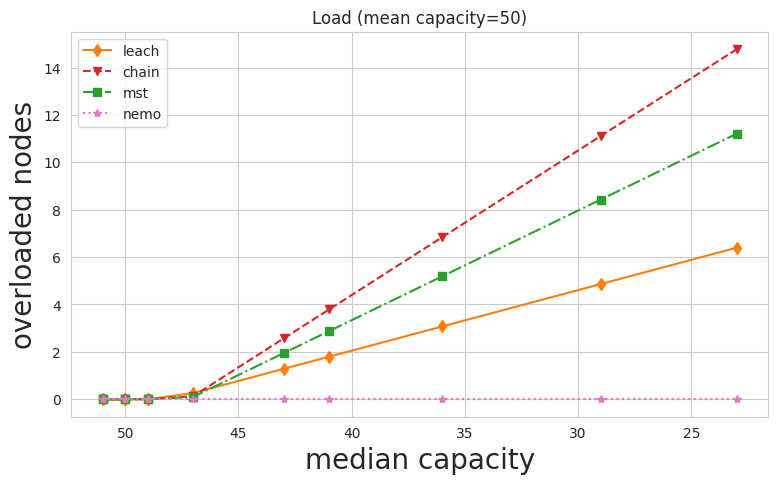

In [79]:
fig, ax = plt.subplots(figsize=(9, 5))
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
styles = ["-", "--", "-.", ":", "-.", "-"]
i = 0
for fam in load_dict.keys():
    vals = load_dict[fam]
    evcol = fam
    print(fam, medians)
    print(fam, vals)
    m, b = np.polyfit(medians, vals, 1)
    if fam == "dt":
        fam = "direct_trx"
        continue
    if fam == "nemo_dc":
        fam = "nemo"
    ax.plot(medians, (m * medians + b).clip(min=0), marker=markers[i], label=fam, linestyle=styles[i],
            color=eval_colors[evcol])
    i = i + 1

ax.invert_xaxis()
ax.set_xlabel("median capacity")
ax.set_ylabel("overloaded nodes")
#ax.set_yscale('log')
ax.legend()

ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

plt.savefig("plots/fit/eval_load_abs.svg")
ax.set_title("Load (mean capacity=" + str(avg) + ")")
plt.show()


In [80]:
load_dict.keys()

dict_keys(['dt', 'leach', 'chain', 'mst', 'nemo_dc'])

leach - d #ff7f0e : [0.0, 0.0, 0.0, 0.0, 0.11627906976744186, 0.11627906976744186, 0.3488372093023256, 0.46511627906976744, 1.1627906976744187, 2.0930232558139537, 7.674418604651162, 22.093023255813954]
chain -- v #d62728 : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.728538283062645]
mst -. s #2ca02c : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.185185185185185]
nemo : * #e377c2 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


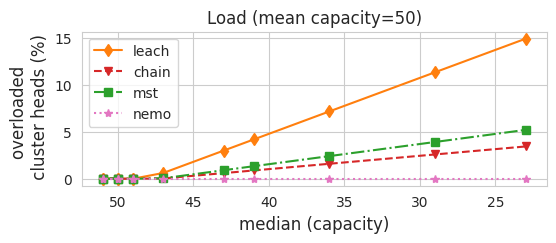

In [81]:
fig, ax = plt.subplots(figsize=(6, 2))
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
styles = ["-", "--", "-.", ":", "-.", "-"]
i = 0
for fam in load_dict.keys():
    vals = load_dict[fam]
    evcol = fam
    if fam == "dt":
        fam = "direct_trx"
        vals = [100 for x in vals]
        continue
    if fam == "leach":
        vals = [x / num_leach_clusters * 100 for x in vals]
    if fam == "mst":
        agg_points = (device_number - 1) / 2
        vals = [x / agg_points * 100 for x in vals]
    if fam == "chain":
        agg_points = device_number - 2
        vals = [x / agg_points * 100 for x in vals]
    if fam == "nemo_dc":
        fam = "nemo"
    m, b = np.polyfit(medians, vals, 1)
    print(fam, styles[i], markers[i], eval_colors[evcol], ":", vals)
    ax.plot(medians, (m * medians + b).clip(min=0), marker=markers[i], label=fam, linestyle=styles[i],
            color=eval_colors[evcol])
    i = i + 1

ax.invert_xaxis()
ax.set_xlabel("median (capacity)")
ax.set_ylabel("overloaded \n cluster heads (%)")
#ax.set_yscale('log')
ax.legend()

ax.yaxis.label.set_size(12)
ax.xaxis.label.set_size(12)

plt.savefig("plots/fit/eval_load_perc.svg")
ax.set_title("Load (mean capacity=" + str(avg) + ")")
plt.show()

In [82]:
quant_dict

{'dt': 22.87,
 'mst': 56.12,
 'leach': 24.89,
 'chain': 1533.59,
 'nemo (w=1, m=50)': 22.94,
 'nemo (w=1, m=25)': 24.69,
 'nemo (w=2, m=50)': 24.98,
 'nemo (w=2, m=25)': 26.96,
 'nemo (w=ln[1, 50], m=50)': 27.47,
 'nemo (w=ln[1, 50], m=25)': 28.54}

In [83]:
mean_dict

{'dt': 15.49,
 'mst': 37.46,
 'leach': 16.81,
 'chain': 848.67,
 'nemo (w=1, m=50)': 15.94,
 'nemo (w=1, m=25)': 17.52,
 'nemo (w=2, m=50)': 18.4,
 'nemo (w=2, m=25)': 19.33,
 'nemo (w=ln[1, 50], m=50)': 18.83,
 'nemo (w=ln[1, 50], m=25)': 20.06}